**Module Paths**

In [1]:
import os

os.chdir("../../")

# Putting everything together

Train the model and validate it against the validation set.

Let's start by defining a few hyperparameters

In [2]:
batch_size = 128  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.15  # fraction of the training data to reserve for validation
num_epochs = 100  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = "adam"  # optimizer. 'sgd' or 'adam'
weight_decay = 0.0005  # regularization. Increase this to combat overfitting
label_smoothing = 0.1  # Same as before to handle label noise
clip_value = 0.5  # Lower clip value to prevent large gradient updates
save_path = "checkpoints/model_transfer.pt"
early_stopping_patience = 15  # Allow some epochs for potential improvement

## Import necessary components

In [3]:
from cnn.landmark_classification.src.data import get_data_loaders
from cnn.landmark_classification.src.train import optimize, one_epoch_test
from cnn.landmark_classification.src.optimizer import get_optimizer, get_loss
from cnn.landmark_classification.src.transfer import get_model_transfer_learning

## Training

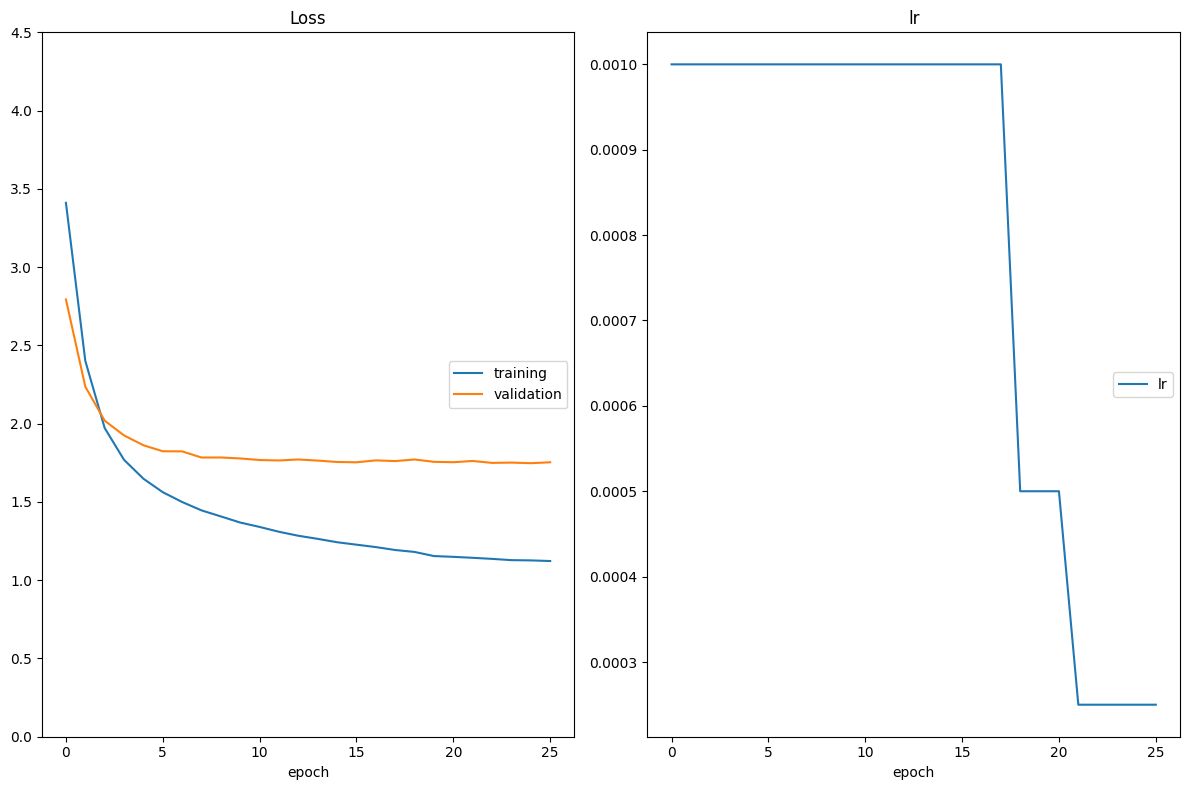

Epoch: 27 	Training Loss: 1.121327 	Validation Loss: 1.753062
No improvement for 15 epochs.
Early stopping triggered after 15 epochs of no improvement.


In [6]:
# Set up data loaders using batch_size and valid_size defined above
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# Instantiate model with num_classes and dropout
model_transfer = get_model_transfer_learning()

# Get the optimizer with the specified model, learning rate, optimizer type, and weight decay
optimizer = get_optimizer(
    model_transfer,
    optimizer=opt,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
)

# Get the loss function
loss = get_loss(label_smoothing=label_smoothing)

# Run the optimization process
optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path=save_path,
    interactive_tracking=True,
    early_stopping_patience=early_stopping_patience,
    clip_value=clip_value,
)

## Testing

In [8]:
import torch

model_transfer = get_model_transfer_learning()

# Load the weights from the checkpoint
model_transfer.load_state_dict(torch.load(save_path, weights_only=True))

# device
from utils.device import get_device

device = get_device()
model_transfer = model_transfer.to(device)

# Run test
one_epoch_test(data_loaders["test"], model_transfer, loss)

Test Loss: 1.631672
Test Accuracy: 72.40%


1.631672137069702

In [2]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
dropout = 0.5  # dropout for our model
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = "sgd"  # optimizer. 'sgd' or 'adam'
weight_decay = 0.01  # regularization. Increase this to combat overfitting
momentum = 0.9
label_smoothing = 0.1
negative_slope = 0.01
clip_value = 1.0
save_path = "checkpoints/best_val_loss_leaky.pt"
early_stopping_patience = 15

In [3]:
from cnn.landmark_classification.src.data import get_data_loaders
from cnn.landmark_classification.src.train import optimize, one_epoch_test
from cnn.landmark_classification.src.optimizer import get_optimizer, get_loss
from cnn.landmark_classification.src.model import MyLeakyModel
from model.helper import initialize_weights

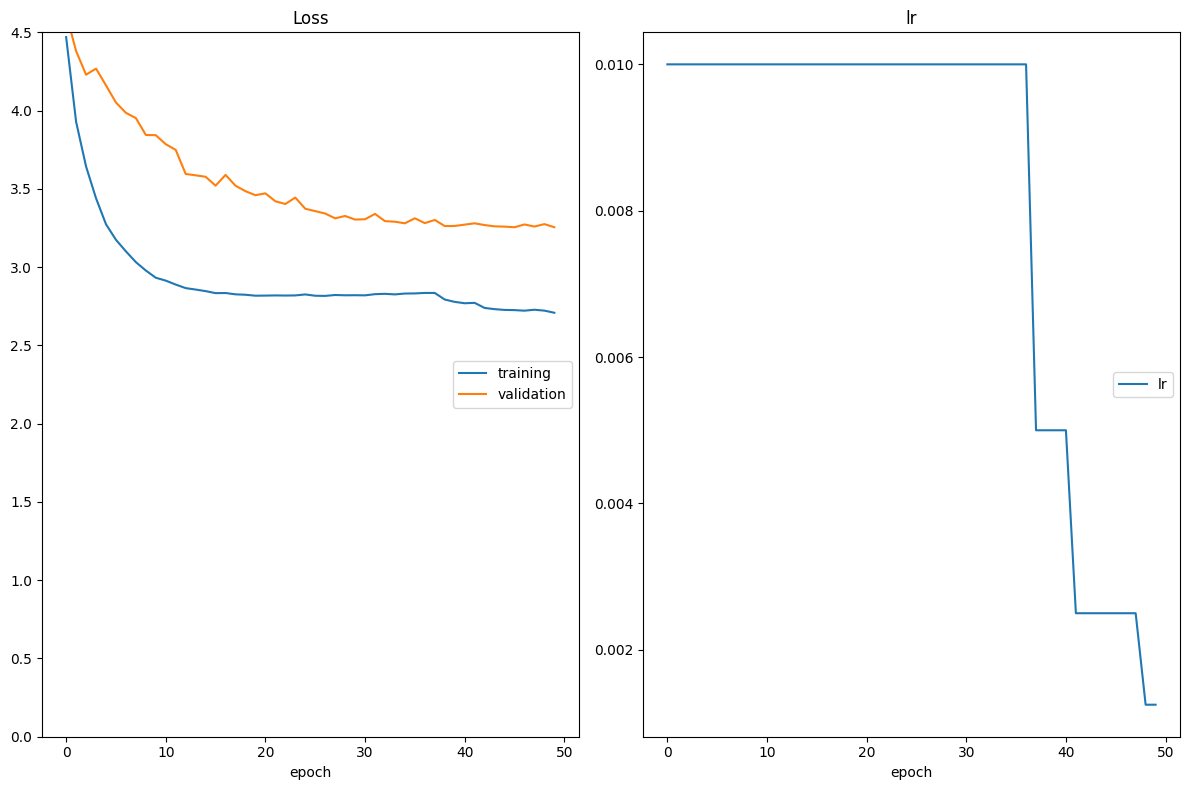

In [4]:
# Set up data loaders using batch_size and valid_size defined above
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# Instantiate model with num_classes, dropout and negative slope
model = MyLeakyModel(
    num_classes=num_classes, dropout=dropout, negative_slope=negative_slope
)
model.apply(initialize_weights)

# Get the optimizer with the specified model, learning rate, optimizer type, and weight decay
optimizer = get_optimizer(
    model,
    optimizer=opt,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    momentum=momentum,
)

# Get the loss function
loss = get_loss(label_smoothing=label_smoothing)

# Run the optimization process
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path=save_path,
    interactive_tracking=True,
    early_stopping_patience=early_stopping_patience,
    clip_value=clip_value,
)

In [5]:
# Run test
one_epoch_test(data_loaders["test"], model, loss)

Test Loss: 3.201362
Test Accuracy: 42.16%


3.20136247215271

# Torch Script

In [15]:
save_path = "checkpoints/model_transfer.pt"

In [17]:
from cnn.landmark_classification.src.predictor import Predictor
from data.helper import calculate_mean_std
from cnn.landmark_classification.src.transfer import get_model_transfer_learning
from cnn.landmark_classification.src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = get_model_transfer_learning().cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model_transfer.load_state_dict(
    torch.load(save_path, map_location="cpu", weights_only=True)
)

# Let's wrap our model using the predictor class
mean, std = calculate_mean_std(data_loaders["train"].dataset.dataset)
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/transfer_exported.pt")

Loading mean and std from cache: mean_and_std.pt.local
Dataset mean: tensor([0.4675, 0.4715, 0.4643]), std: tensor([0.2185, 0.2184, 0.2382])
Training set size: 3996, Validation set size: 1000, Test set size: 1250
Loading mean and std from cache: mean_and_std.pt.local


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [20]:
import torch

# Load the scripted model from the file
model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

In [21]:
from cnn.landmark_classification.src.predictor import predictor_test

pred, truth = predictor_test(data_loaders["test"], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [00:20<00:00, 59.85it/s]

Accuracy: 0.724


Finally, let's have a look at the confusion matrix of the fine tuned model we are going to use in production:

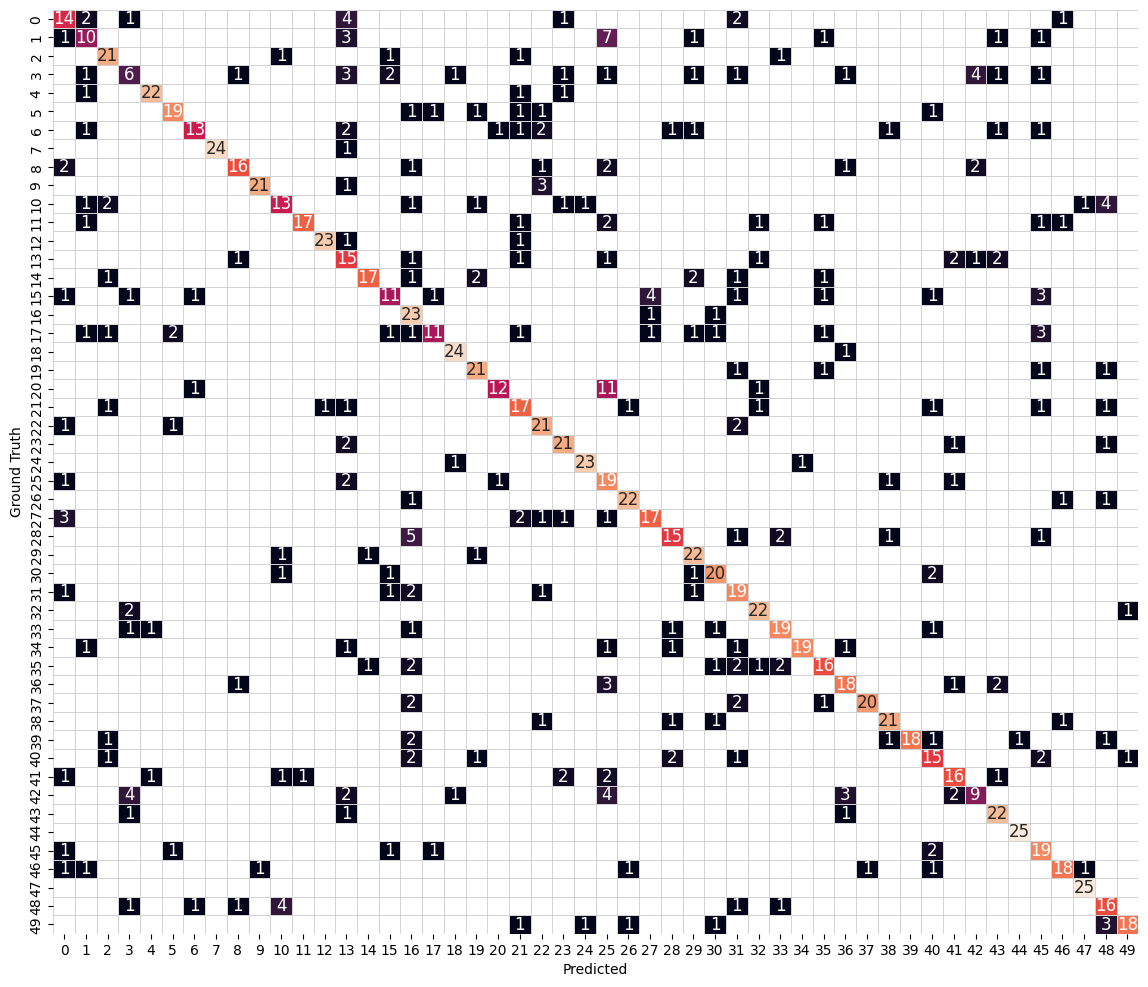

In [22]:
from cnn.landmark_classification.src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)